In [1]:
import numpy as np
import matplotlib.pyplot as plt

# Exercise 1

What is the total frequency search range for L2 and L5 carrier, if the TCXO has the following specifications:

TCXO offset within +-3ppm

In [2]:
tcxo_offset = 3e-6
f_L1 = 1575.42e6
f_L2 = 1227.60e6
f_L5 = 1176.45e6
f_L1_offset = f_L1 * tcxo_offset
f_L2_offset = f_L2 * tcxo_offset
f_L5_offset = f_L5 * tcxo_offset
print(f"L5 Doppler search range: {-f_L5_offset} Hz to {f_L5_offset} Hz")
print(f"L2 Doppler search range: {-f_L2_offset} Hz to {f_L2_offset} Hz")
print(f"L1 Doppler search range: {-f_L1_offset} Hz to {f_L1_offset} Hz")

L5 Doppler search range: -3529.35 Hz to 3529.35 Hz
L2 Doppler search range: -3682.8 Hz to 3682.8 Hz
L1 Doppler search range: -4726.26 Hz to 4726.26 Hz


# Exercise 2

How long does it take for an L2C code and an L5 code to mis-align by ½ chip due to Doppler frequency?

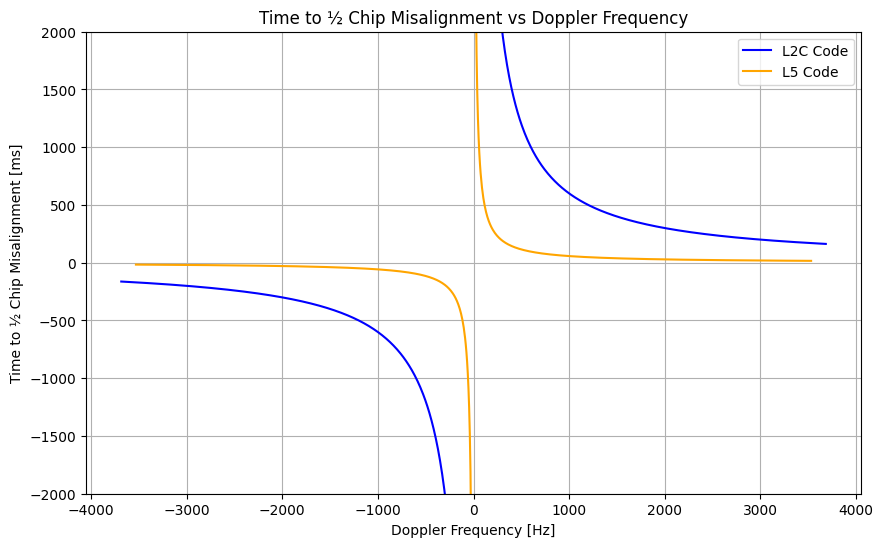

In [ ]:
code_rate_L2C = 1.023e6  # chips per second
code_rate_L5 = 10.23e6  # chips per second

f_L1 = 1575.42e6
f_L2 = 1227.60e6
f_L5 = 1176.45e6
speed_of_light = 299792458  # meters per second
v_LOS_eff = speed_of_light * tcxo_offset  # effective TCXO rate in m/s

num_steps = 1000
time_rate_offset = np.linspace(-tcxo_offset, tcxo_offset, num_steps)  # Hz
doppler_arr_L2C = f_L2 * time_rate_offset
doppler_arr_L5 = f_L5 * time_rate_offset

misalignment_amount = 0.5
time_to_half_chip_L2C = misalignment_amount / code_rate_L2C / time_rate_offset
time_to_half_chip_L5 = misalignment_amount / code_rate_L5 / time_rate_offset
time_to_half_chip_L2C[num_steps // 2 - 1: num_steps // 2 + 1] = np.nan  # avoid division by zero
time_to_half_chip_L5[num_steps // 2 - 1: num_steps // 2 + 1] = np.nan  # avoid division by zero

fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111)
ax.plot(doppler_arr_L2C, time_to_half_chip_L2C * 1e3, label="L2C Code", color="blue")
ax.plot(doppler_arr_L5, time_to_half_chip_L5 * 1e3, label="L5 Code", color="orange")
ax.set_xlabel("Doppler Frequency [Hz]")
ax.set_ylabel("Time to ½ Chip Misalignment [ms]")
ax.set_ylim(-2e3, 2e3)
ax.set_title("Time to ½ Chip Misalignment vs Doppler Frequency")
ax.legend()
ax.grid()
plt.show()

# Exercise 3

What is the computation cost (in terms of number of multiplications and additions) of time domain correlation of 1 ms of GPS L1 CA signal, assuming that the signal is sampled at 5 MHz.

(TODO: This exercise needs to be re-written)

Assume that our received signal samples and replica signal are stored in memory.  We ignore memory access time and focus only on the number of arithmetic operations.

For $N$ samples, we need $N$ multiplications and $N-1$ additions to compute the correlation value for one code phase.  This result is $\mathcal{O}(N)$.

If we want to compute the correlation for all possible code phases, we need to repeat this for each code phase of interest.  Since 1 ms is equal to one CA code period, and the sampling frequency is 5 MHz, we have $N = 5000$ samples in 1 ms.  If we check each possible code phase at the resolution corresponding to this sampling rate ($\Delta\eta = 1.023\cdot 10^6 / f_\text{samp} \approx 0.2$ chips), we have $N$ code phases to check.

In [4]:
samp_rate = 5e6
chip_rate = 1.023e6
code_phase_resolution = chip_rate / samp_rate
print(f"Code phase resolution: {code_phase_resolution} chips")

Code phase resolution: 0.2046 chips


# Exercise 4

Implement a function that performs acquisition using the time domain correlation method.  You need to demonstrate that your program works with at least 3 sets of data. For all 3 sets of data, f0 = 1.25e6, and sampling frequency is 5MHZ, bit resolution is 4-bit. Try using the following parameters in your simulated signal: PRN =[4 7 10 15];   CN0 =[45 47 49 45]; n0 = [100 1225 2500 4999];     Initial phase phi = [0 0.5 1.2 1.34] radians;   fd = [1000 1000 2200 3000] Hz;​

See `lecture-8/simulate-gps-signal.ipynb` for reference on how to simulate the signals.

Here we use a simpler linear signal model to simulate the received signal.

The original exercise wording uses code phase in units of samples, denoted as `n0`.  In this notebook, we use code phase in units of seconds or chips, denoted as `eta0`.  Conversion between the two more generally depends on whether Doppler expansion/compression of the code is taken into account.  Here, since we are considering L1 signals with < 5 kHz Doppler, we can ignore this effect for simplicity.

```python
fs = 5e6  # samples per second
chip_rate = 1.023e6  # chips per second
n0 = 2500  # code phase in samples
eta0 = n0 / fs  # converts code phase from samples to seconds
eta0_chips = eta0 * chip_rate  # converts code phase from seconds to chips
```

In [ ]:
import numpy as np
from dataclasses import dataclass
import utils.signals.gps_l1ca as gps_l1ca_utils

@dataclass
class SignalParams:
    prn: int
    cn0: float  # in dB-Hz
    n0: int     # initial sample code phase
    initial_phase: float  # in radians
    fd: float   # Doppler frequency in Hz

signal_params = {
    4: SignalParams(prn=4, cn0=45, n0=100, initial_phase=0.0, fd=1000),
    7: SignalParams(prn=7, cn0=47, n0=1225, initial_phase=0.5, fd=1000),
    10: SignalParams(prn=10, cn0=49, n0=2500, initial_phase=1.2, fd=2200),
    15: SignalParams(prn=15, cn0=45, n0=4999, initial_phase=1.34, fd=3000),
}

samp_rate = 5e6  # 5 MHz
sim_duration = 0.1  # seconds
sim_time_arr = np.arange(0, sim_duration, 1.0 / samp_rate)
sim_num_samples = len(sim_time_arr)

# First, compute the noise power based on receiver equivalent noise temperature and front-end bandwidth
k_boltzmann = 1.380649e-23  # J/K
rx_sys_temp_k = 535.0  # Kelvin
front_end_bw_hz = samp_rate  # Hz
noise_power_watts = k_boltzmann * rx_sys_temp_k * front_end_bw_hz

noise_samples = np.sqrt(noise_power_watts) * (
    np.random.randn(sim_num_samples) + 1j * np.random.randn(sim_num_samples)
) / np.sqrt(2)

noise_free_signal_samples = np.zeros(sim_num_samples, dtype=complex)

for prn, params in signal_params.items():
    sat_cn0_dBHz = params.cn0
    signal_power = noise_power_watts / front_end_bw_hz * 10**(sat_cn0_dBHz / 10)
    signal_amp = np.sqrt(signal_power)

    code_seq = 1 - 2 * gps_l1ca_utils.generate_code_sequence_L1CA(prn).astype(np.int8)
    eta0 = params.n0 / samp_rate  # initial code phase in seconds
    code_phase_chips = (eta0 + sim_time_arr) * gps_l1ca_utils.CODE_RATE
    code_chip_indices = (code_phase_chips).astype(int) % gps_l1ca_utils.CODE_LENGTH
    code_samples = code_seq[code_chip_indices]

    num_data_bits = int(np.ceil(sim_duration * gps_l1ca_utils.DATA_SYMBOL_RATE))
    data_bits = np.random.choice([-1, 1], size=num_data_bits)
    data_bit_indices = ((eta0 + sim_time_arr) * gps_l1ca_utils.DATA_SYMBOL_RATE).astype(int) % num_data_bits
    data_samples = data_bits[data_bit_indices]

    carrier_phase = 2 * np.pi * (params.fd * sim_time_arr + params.initial_phase / (2 * np.pi))
    carrier_samples = np.exp(1j * carrier_phase)

    signal_samples = signal_amp * code_samples * data_samples * carrier_samples
    noise_free_signal_samples += signal_samples

baseband_samples = noise_free_signal_samples + noise_samples

num_quant_bits = 4
num_quant_levels = 2**num_quant_bits
# assume even quantization levels between +/- max_signal_amp
#  (sometimes this quantization doesn"t quite work as expected; it"s not that important though -- it should be close enough)
max_signal_amp = np.max(np.abs(baseband_samples))
quantized_samples_real = np.floor(np.real(baseband_samples) / max_signal_amp * (num_quant_levels / 2))
quantized_samples_imag = np.floor(np.imag(baseband_samples) / max_signal_amp * (num_quant_levels / 2))
quantized_samples = quantized_samples_real + 1j * quantized_samples_imag

In [31]:
def delay_doppler_correlate_gps_l1ca_signal(
        received_samples: np.ndarray,
        prn: int,
        min_doppler_hz: float,
        max_doppler_hz: float,
        samp_rate: float,
        doppler_step_hz: float | None = None,
        print_progress: bool = True,
) -> None:
    code_seq = 1 - 2 * gps_l1ca_utils.generate_code_sequence_L1CA(prn).astype(np.int8)
    num_samples = len(received_samples)
    code_length = gps_l1ca_utils.CODE_LENGTH
    code_rate = gps_l1ca_utils.CODE_RATE

    if doppler_step_hz is None:
        doppler_step_hz = samp_rate / num_samples  # 1 / T resolution
    doppler_arr_hz = np.arange(min_doppler_hz, max_doppler_hz + doppler_step_hz, doppler_step_hz)
    num_doppler_bins = len(doppler_arr_hz)

    time_arr = np.arange(num_samples) / samp_rate
    code_seq = 1 - 2 * gps_l1ca_utils.get_GPS_L1CA_code_sequence(prn).astype(np.int8)
    code_phase_chips = time_arr * code_rate  # Assume no Doppler expansion/compression
    code_chip_indices = (code_phase_chips).astype(int) % code_length
    code_samples = code_seq[code_chip_indices]
    num_code_phases = len(code_samples)

    # code_samples_fft = np.fft.fft(code_samples)

    correlations = np.zeros((num_doppler_bins, num_code_phases), dtype=complex)
    for i, doppler_freq in enumerate(doppler_arr_hz):
        if print_progress:
            print(f"\rProcessing Doppler bin {i+1}/{num_doppler_bins}: {doppler_freq} Hz", end="")
        carrier_phase = 2 * np.pi * doppler_freq * time_arr
        conj_carrier_samples = np.exp(-1j * carrier_phase)

        wipeoff_samples = received_samples * conj_carrier_samples

        for j in range(num_code_phases):
            shifted_code_samples = np.roll(code_samples, j)
            correlations[i, j] = np.sum(wipeoff_samples * shifted_code_samples)

        # FFT correlation
        # wipeoff_samples_fft = np.fft.fft(wipeoff_samples)
        # corr = np.fft.ifft(wipeoff_samples_fft * np.conj(code_samples_fft))
        # correlations[i, :] = corr
    if print_progress:
        print("\nCorrelation complete.")

    return correlations, doppler_arr_hz

In [32]:
integration_duration = 0.001  # 1 ms
num_coh_samples = int(samp_rate * integration_duration)
min_doppler_hz = -5000
max_doppler_hz = 5000
doppler_step_hz = 1 / integration_duration  # 1 kHz
correlations, doppler_arr_hz = delay_doppler_correlate_gps_l1ca_signal(
    received_samples=quantized_samples[:num_coh_samples],
    prn=10,
    min_doppler_hz=min_doppler_hz,
    max_doppler_hz=max_doppler_hz,
    samp_rate=samp_rate,
    doppler_step_hz=doppler_step_hz,
)

Processing Doppler bin 11/11: 5000.0 Hz
Correlation complete.


Peak correlation at Doppler: 2000.0 Hz, Code Phase: 2500 samples


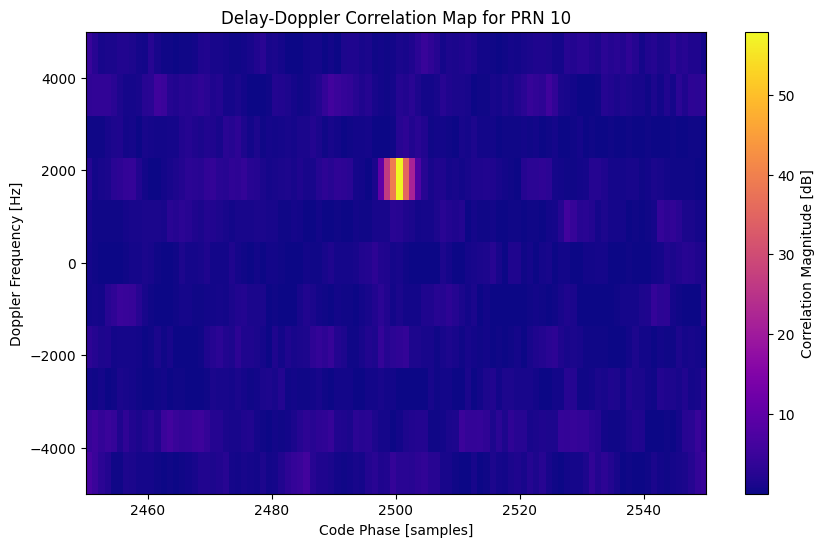

In [33]:
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111)
num_doppler_bins, num_code_phases = correlations.shape
extent = [0, num_code_phases, min_doppler_hz, max_doppler_hz]

norm_corr_power = np.abs(correlations / num_coh_samples)**2
noise_power = np.median(norm_corr_power)
norm_corr_power = norm_corr_power / noise_power
norm_corr_power_dB = 10 * np.log10(norm_corr_power + 1e-12)

peak_doppler_idx, peak_code_phase_idx = np.unravel_index(
    np.argmax(norm_corr_power_dB),
    norm_corr_power_dB.shape,
)
peak_doppler_hz = doppler_arr_hz[peak_doppler_idx]
print(f"Peak correlation at Doppler: {peak_doppler_hz} Hz, Code Phase: {peak_code_phase_idx} samples")

im = ax.imshow(
    norm_corr_power,
    extent=extent,
    aspect="auto",
    interpolation="nearest",
    cmap="plasma",
    origin="lower",
    vmin=noise_power,
)
code_phase_window = 50  # samples
ax.set_xlim(peak_code_phase_idx - code_phase_window, peak_code_phase_idx + code_phase_window)
ax.set_xlabel("Code Phase [samples]")
ax.set_ylabel("Doppler Frequency [Hz]")
ax.set_title("Delay-Doppler Correlation Map for PRN 10")
plt.colorbar(im, label="Correlation Magnitude [dB]")
plt.show()